In [1]:
import random
import os
import matplotlib.pyplot as plt
import tqdm

# Wordle Solver

All the logic in here, but it might be a bit messy

## Loading the words

In [118]:
word_len = 5
rounds = 5000

In [6]:
if os.path.isfile(f'./{word_len}_letter_words.txt'):
    
    print('File exists')
    # if already have 5-letter word file, then read from file
    with open(f'./{word_len}_letter_words.txt', 'r') as f:
        words = [x.strip() for x in f.readlines()]

else:
    
    print('File missing')
    # if no 5-letter word file, have to generate it first
    # get words
    # list taken from https://github.com/raun/Scrabble/blob/master/words.txt - words from scrabble
    words = []

    with open('./words.txt') as f:
        for w in f.readlines():
            w = w.strip().lower()
            if len(w) == word_len:
                words.append(w)

    print(len(words))

    # save file out
    with open(f'./{word_len}_letter_words.txt', 'w+') as f:
        for w in words:
            f.write(w)
            f.write('\n')
            
len(words)

File exists


8938

## Function to get the hint 

In [49]:
# encoding method
# - means this letter doesnt exist
# X means this letter exist but in wrong place
# O means this letter in the correct place

def get_hint(target, guess):
    target_lst = list(target)
    hint = ['-' for _ in range(word_len)]
    for i in range(word_len):
        if guess[i] == target_lst[i]:
            hint[i] = 'O'
            target_lst[i] = None
    for i in range(word_len):
        if hint[i] == '-':
            for j in range(word_len):
                if guess[i] == target_lst[j]:
                    hint[i] = 'X'
                    target_lst[j] = None
                    break
    return "".join(hint)

In [50]:
get_hint('tapes', 'tyres')

'O--OO'

In [51]:
get_hint('tests', 'tspes')

'OX-XO'

In [52]:
get_hint('aabbc', 'aaabb')

'OO-OX'

In [53]:
get_hint('noses', 'adeem')

'---O-'

## Precomputing the hints and saving to a file (if wanted)

In [54]:
if os.path.isfile('hints.txt'):
    
    print('File exists')
    # load precomputation
    hint_dict = dict()
    with open('hints.txt', 'r') as f:
        for ln in f.readlines():
            targ, guess, hint = ln.strip().split(' ')
            hint_dict[targ, guess] = hint
            
else:
    
    print('File missing')
    # do precomputation
    hint_dict = dict()
    for targ in tqdm.tqdm(words):
        for guess in words:
            hint_dict[targ, guess] = get_hint(targ, guess)
            
    # save the precomputation out
    # warning - file gets quite big (1.4GB), so comment out if don't want to save

    with open('hints.txt', 'w+') as f:
        for targ, guess in hint_dict.keys():
            f.write(f'{targ} {guess} {hint_dict[targ, guess]}\n')

  0%|          | 0/8938 [00:00<?, ?it/s]

File missing


100%|██████████| 8938/8938 [10:10<00:00, 14.64it/s]  


In [55]:
hint_dict['table', 'tapes']

'OO-X-'

## Define the game 

It randomises a word, and also gives hints when a guess is made. It also keeps a list of the words still feasible after a guess is made.

In [127]:
class Game:
    
    def __init__(self):
        self.ans = random.choice(words)
        self.guesses = []
        self.possible_words = list(words)
        self.turns = 0
        
    def make_guess(self, guess):
        hint = hint_dict[self.ans, guess]
        new_possible = []
        for w in self.possible_words:
            if hint_dict[w, guess] == hint:
                new_possible.append(w)
        self.possible_words = new_possible
        self.guesses.append((guess, hint))
        self.turns += 1
        return hint
    
    def finished(self):
        return len(self.possible_words) <= 1 and len(self.guesses) > 0 and self.guesses[-1][1] == 'OOOOO'

Cmd-line to play against machine

In [178]:
g = Game()
turn = 1
while not g.finished():
    guess = better_strat(rg, use_all_words=True)
    guess = input(f'Turn {turn} | You guess: ')
    hint = g.make_guess(guess)
    print(f'Turn {turn} | Hint:      {hint}')
    turn += 1

Turn 1 | You guess: maths
Turn 1 | Hint:      -O---
Turn 2 | You guess: walks
Turn 2 | Hint:      -OX--
Turn 3 | You guess: crane
Turn 3 | Hint:      --X-O
Turn 4 | You guess: taped
Turn 4 | Hint:      -O-X-


KeyboardInterrupt: Interrupted by user

In [128]:
g = Game()
g.make_guess('table')
g.ans, g.guesses, len(g.possible_words), g.turns

('mille', [('table', '---OO')], 33, 1)

## Baseline strategy - just guess a random feasible word

In [63]:
def naive_strategy(game):
    return random.choice(game.possible_words)

In [64]:
g = Game()
while not g.finished():
    guess = naive_strategy(g)
    hint = g.make_guess(guess)
    print(guess, hint)

exine X-X--
pieta -OX--
sizes -O-O-
cider -O-O-
libel OO-O-
limey OOOOO


In [129]:
naive_results = [0.]

for _ in tqdm.trange(rounds):
    g = Game()
    while not g.finished():
        guess = naive_strategy(g)
        hint = g.make_guess(guess)

    while len(naive_results) <= g.turns:
        naive_results.append(0.)
    naive_results[g.turns] += 1.

100%|██████████| 5000/5000 [04:40<00:00, 17.81it/s]


Bad Method

Mean number of guesses =  4.8882
Games needing over six guesses =  579.0 out of 5000.0


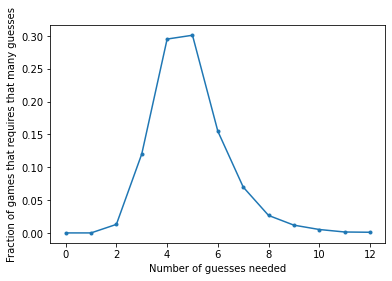

In [183]:
print('Bad Method')
print()
print('Mean number of guesses = ', sum(i * x for (i, x) in enumerate(naive_results)) / sum(naive_results))
print('Games needing over six guesses = ', sum(naive_results[7:]), 'out of', sum(naive_results))
plt.plot([x / sum(naive_results) for x in naive_results], '.-')
plt.xlabel('Number of guesses needed')
plt.ylabel('Fraction of games that requires that many guesses')
plt.show()

## Better strategy - guess the word that minimises remaining feasible word

In [162]:
round_one_memorise = None     # memorise best first move
round_two_memorise = dict()   # memorise best second move if we allow guessing any word


def better_strat(game, use_all_words=False):
    
    global round_one_memorise  # too lazy to write properly so using global here
    global round_two_memorise
    
    # can we use any precomputation
    if game.turns == 0 and round_one_memorise is not None:
        return round_one_memorise
    elif game.turns == 1 and use_all_words:
        first_round_hint = game.guesses[0][1]
        if first_round_hint in round_two_memorise.keys():
            return round_two_memorise[first_round_hint]
    elif len(game.possible_words) == 1:
        # one word left, just guess that word
        return game.possible_words[0]

    best_next_guess = None
    best_score = len(game.possible_words) + 1
    # iterate through all words to check, compute its expected remaining feasible words
    for w in (words if use_all_words else game.possible_words):
        counter = dict()
        for targ in game.possible_words:
            hint = hint_dict[targ, w]
            if hint in counter.keys():
                counter[hint] += 1
            else:
                counter[hint] = 1
        score = sum(x**2 for x in counter.values()) / len(game.possible_words)
        if score < best_score or (score == best_score and w in game.possible_words):  # prioritise words that are feasible
            best_score = score
            best_next_guess = w
    
    # if computed, get the value memorised
    if game.turns == 0:
        round_one_memorise = best_next_guess
    elif game.turns == 1 and use_all_words:
        round_two_memorise[first_round_hint] = best_next_guess
            
    return best_next_guess

In [163]:
g = Game()
while not g.finished():
    guess = better_strat(g)
    hint = g.make_guess(guess)
    print(guess, hint)

lares -XXX-
tread -XOO-
anear OOOOO


In [164]:
round_one_memorise

'lares'

Testing for better method but only using feasible words

In [165]:
our_validonly_results = [0.]

for _ in tqdm.trange(rounds):
    g = Game()
    while not g.finished():
        guess = better_strat(g)
        hint = g.make_guess(guess)
        
    while len(our_validonly_results) <= g.turns:
        our_validonly_results.append(0.)
    our_validonly_results[g.turns] += 1

100%|██████████| 5000/5000 [06:46<00:00, 12.31it/s]


Our method, but can only guess feasible words

Mean number of guesses =  4.3906
Number of games needing over six guesses =  367.0 out of 5000.0


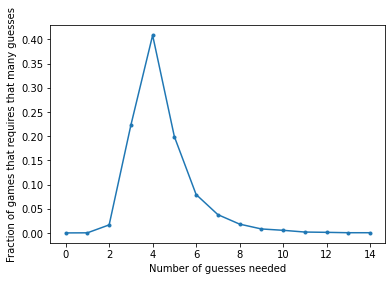

In [185]:
print('Our method, but can only guess feasible words')
print()
print('Mean number of guesses = ', sum(i * x for (i, x) in enumerate(our_validonly_results)) / sum(our_validonly_results))
print('Number of games needing over six guesses = ', sum(our_validonly_results[7:]), 'out of', sum(our_validonly_results))
plt.plot([x / sum(our_validonly_results) for x in our_validonly_results], '.-')
plt.xlabel('Number of guesses needed')
plt.ylabel('Fraction of games that requires that many guesses')
plt.show()

Testing better method but allowing any words as a guess

In [198]:
g = Game()
while not g.finished():
    guess = better_strat(g, use_all_words=True)
    hint = g.make_guess(guess)
    print(guess, hint)

lares ----X
hoist --OX-
spunk O--OO
swink O-OOO
skink OOOOO


In [168]:
our_allwords_results = [0.]

for _ in tqdm.trange(rounds):
    g = Game()
    while not g.finished():
        guess = better_strat(g, use_all_words=True)
        hint = g.make_guess(guess)
        
    while len(our_allwords_results) <= g.turns:
        our_allwords_results.append(0.)
    our_allwords_results[g.turns] += 1

100%|██████████| 5000/5000 [14:36<00:00,  5.70it/s] 


Our method, and the computer can guess any valid English word

Mean number of guesses =  3.986
Number of games needing over six guesses =  2.0 out of 5000.0


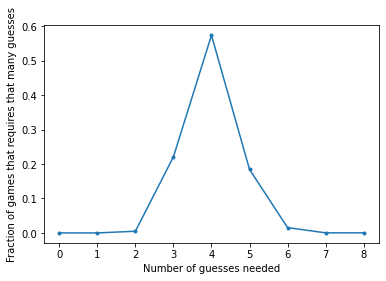

In [186]:
print('Our method, and the computer can guess any valid English word')
print()
print('Mean number of guesses = ', sum(i * x for (i, x) in enumerate(our_allwords_results)) / sum(our_allwords_results))
print('Number of games needing over six guesses = ', sum(our_allwords_results[7:]), 'out of', sum(our_allwords_results))
plt.plot([x / sum(our_allwords_results) for x in our_allwords_results], '.-')
plt.xlabel('Number of guesses needed')
plt.ylabel('Fraction of games that requires that many guesses')
plt.show()

Comparing number of guesses needed between each strategies


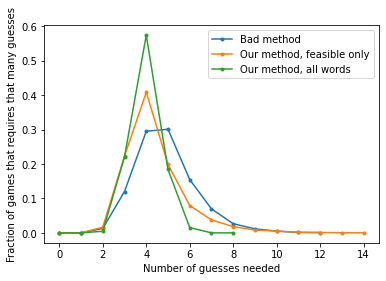

In [188]:
print('Comparing number of guesses needed between each strategies')
plt.plot([x / sum(naive_results) for x in naive_results],                 '.-', label='Bad method')
plt.plot([x / sum(our_validonly_results) for x in our_validonly_results], '.-', label='Our method, feasible only')
plt.plot([x / sum(our_allwords_results) for x in our_allwords_results],   '.-', label='Our method, all words')
plt.legend()
plt.xlabel('Number of guesses needed')
plt.ylabel('Fraction of games that requires that many guesses')
plt.show()

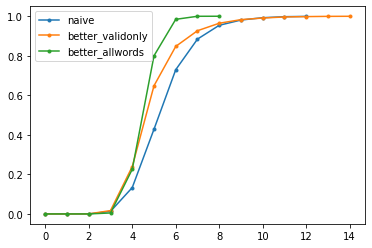

In [171]:
plt.plot([sum(naive_results[:i]) / sum(naive_results) for i in range(len(naive_results))],                         '.-', label='naive')
plt.plot([sum(our_validonly_results[:i]) / sum(our_validonly_results) for i in range(len(our_validonly_results))], '.-', label='better_validonly')
plt.plot([sum(our_allwords_results[:i]) / sum(our_allwords_results) for i in range(len(our_allwords_results))],    '.-', label='better_allwords')
plt.legend()
plt.show()

## Reverse game - solver for the Wordle game as command line

In [152]:
class ReverseGame:
    
    def __init__(self):
        self.guesses = []
        self.possible_words = list(words)
        self.turns = 0
        
    def update_hint(self, guess, hint):
        new_possible = []
        for w in self.possible_words:
            if hint_dict[w, guess] == hint:
                new_possible.append(w)
        self.possible_words = new_possible
        self.guesses.append((guess, hint))
        self.turns += 1
        return hint
    
    def finished(self):
        return len(self.possible_words) <= 1 and len(self.guesses) > 0 and self.guesses[-1][1] == 'OOOOO'

In [172]:
rg = ReverseGame()
turn = 1
while not rg.finished():
    guess = better_strat(rg, use_all_words=True)
    hint = input(f'Turn {turn} | Possible words = {len(rg.possible_words):4d} | Computer guesses "{guess}" | Hint = ')
    hint = hint.upper()
    if len(hint) == 5 and set(hint).issubset({'O', 'X', '-'}):
        rg.update_hint(guess, hint)
        turn += 1

Turn 1 | Possible words = 8938 | Computer guesses "lares" | Hint = -o---
Turn 2 | Possible words =  252 | Computer guesses "minty" | Hint = --oxo
Turn 3 | Possible words =    1 | Computer guesses "tangy" | Hint = ooooo


## Guess diagnostics - how good is a certain guess, based on how well it can filter out words

In [200]:
guess = 'lares'

counter = dict()
for targ in words:
    hint = get_hint(targ, guess)
    if hint in counter.keys():
        counter[hint] += 1
    else:
        counter[hint] = 1
score = sum(x**2 for x in counter.values()) / len(words)

print("Word =", guess)
print("Mean remaining feasible words =", score)
counter_lst = [(k, counter[k]) for k in counter.keys()]
counter_lst.sort(key=lambda x: -x[1])
for kv in counter_lst:
    print(kv)

Word = lares
Mean remaining feasible words = 193.59118371000224
('-----', 576)
('----O', 509)
('---X-', 366)
('---O-', 263)
('-X---', 253)
('-O---', 252)
('---OO', 236)
('--XO-', 234)
('----X', 232)
('X----', 225)
('--X--', 218)
('-O--O', 208)
('-X--O', 203)
('XX---', 196)
('---XO', 193)
('--XX-', 188)
('X---O', 182)
('-XX--', 167)
('X--X-', 162)
('---XX', 161)
('-X-X-', 154)
('--X-O', 118)
('-X--X', 116)
('-XXX-', 111)
('-O-OO', 98)
('--O-O', 98)
('-O-O-', 97)
('XX-X-', 94)
('X--O-', 89)
('--O--', 89)
('XO---', 77)
('-OXO-', 77)
('-XX-O', 75)
('XX--O', 73)
('X---X', 70)
('X--XO', 69)
('--OX-', 69)
('-O--X', 68)
('-X-XX', 67)
('---OX', 66)
('-OX--', 63)
('-OO-O', 62)
('--XXO', 62)
('--X-X', 61)
('-X-XO', 57)
('XO--O', 57)
('-OO--', 56)
('O---O', 51)
('O----', 48)
('-XO--', 47)
('XX--X', 47)
('XXX--', 46)
('-O-X-', 44)
('--XOO', 41)
('X--OO', 40)
('--XXX', 40)
('X-X--', 39)
('--O-X', 39)
('-XX-X', 38)
('X--XX', 38)
('--OO-', 37)
('--XOX', 37)
('--OXO', 36)
('X-XO-', 36)
('--OOO', 32)
('

## Calculating the good guesses and bad guesses

In [57]:
good_guess = []
bad_guess = []

for guess in tqdm.tqdm(words):
    counter = dict()
    for targ in words:
        hint = hint_dict[targ, guess]
        if hint in counter.keys():
            counter[hint] += 1
        else:
            counter[hint] = 1
    score = sum(x**2 for x in counter.values()) / len(words)
    if score < 0.03 * len(words):  # good guess = expected to filter down to 3% words remaining (arbitary percentage)
        good_guess.append((guess, score))
    elif score > 0.3 * len(words):  # bad guess = expected to filter down to more than 30% (arbitrary percentage)
        bad_guess.append((guess, score))

100%|██████████| 8938/8938 [03:12<00:00, 46.32it/s]


In [58]:
good_guess.sort(key=lambda x: x[1])
for x in good_guess:
    print(x)

('lares', 193.59118371000224)
('rales', 195.73595882747819)
('tares', 205.4338778250168)
('arles', 205.81270977847393)
('nares', 209.0597449093757)
('rates', 210.9941821436563)
('saner', 214.1709554710226)
('serai', 214.456477959275)
('aloes', 216.19803087939135)
('tales', 216.81024837771312)
('reals', 219.70418438129335)
('lears', 221.92817185052584)
('lanes', 223.48109196688299)
('seral', 224.29402550906244)
('lores', 227.10472141418663)
('roles', 229.8048780487805)
('earls', 231.0895054822108)
('sorel', 232.52248825240545)
('cares', 234.8655180129783)
('raise', 235.145222644887)
('tears', 236.21056164690089)
('laser', 236.53658536585365)
('aures', 237.72051913179683)
('riles', 238.9850078317297)
('nates', 239.73081226225105)
('nears', 240.12575520250616)
('dares', 240.26941150145447)
('orles', 241.3327366301186)
('aeons', 242.00044752741104)
('races', 242.2141418661893)
('tores', 243.97672857462518)
('teals', 245.65831282166033)
('toeas', 246.3394495412844)
('mares', 247.15618706645

In [59]:
bad_guess.sort(key=lambda x: -x[1])
for x in bad_guess:
    print(x)

('xylyl', 3647.4936227343924)
('immix', 3566.0203624972028)
('fuzzy', 3540.9935108525397)
('yukky', 3524.980756321325)
('bubby', 3497.5048109196687)
('jugum', 3460.0214813157304)
('yummy', 3282.5627657194004)
('mummy', 3279.3125978966214)
('yuppy', 3241.397628104721)
('puppy', 3231.903557842918)
('fluff', 3159.5012307003803)
('civic', 3147.9501006936675)
('muzzy', 3118.1678227791454)
('kudzu', 3114.0928619377937)
('boffo', 3110.5497874244797)
('oxbow', 3079.5406131125533)
('kibbi', 3075.7934660997985)
('jinni', 3062.4179906019244)
('whizz', 3055.153278138286)
('vivid', 3040.616916536138)
('phpht', 3036.277019467442)
('vuggy', 3033.7496084135155)
('duddy', 2959.1221749832175)
('buffy', 2952.2821660326695)
('fuggy', 2935.4282837323785)
('chuff', 2875.455582904453)
('jiffy', 2867.2933542179458)
('fizzy', 2854.266055045872)
('butut', 2836.0801074065785)
('zizit', 2815.8740210337883)
('huffy', 2799.8167375251733)
('chuck', 2775.521816961289)
('quiff', 2769.2503915864845)
('mamma', 2762.9903